In [ ]:
from pathlib import Path
from scipy.io import loadmat
import sys
import os

# Use the actual notebook working directory
nb_dir = Path.cwd()
print(f"Current notebook path: {nb_dir}")

# Optionally add the notebook dir (for local-only imports)
if str(nb_dir) not in sys.path:
    sys.path.insert(0, str(nb_dir))
    print(f"Added {nb_dir} to sys.path")

# Critically: add the repository root so top-level packages like 'utils' are importable
# Notebook path: /home/luky/skola/KalmanNet-main/navigation NCLT dataset/linear_velocity_integration
# Repo root is two levels up: /home/luky/skola/KalmanNet-main
repo_root = nb_dir.parents[1]
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))
    print(f"Added {repo_root} to sys.path")

In [2]:
import torch
import matplotlib.pyplot as plt
from utils import trainer
from utils import utils
from Systems import DynamicSystem
import Filters
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from scipy.io import loadmat
from scipy.interpolate import RegularGridInterpolator
import random

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda


Načítám soubor: ../ground_truth/groundtruth_2012-01-22.csv...


/tmp/ipykernel_204765/1350448941.py:21: DtypeWarning: Columns (1,2,3,4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, header=None, names=['time', 'x', 'y', 'z', 'r', 'p', 'h'])



✅ Data seřazena do formátu [px, vx, py, vy]. Shape: (5210, 4)
Měření vygenerována (Simulace GPS+Odo). Shape: torch.Size([5210, 4])
  -> Šum polohy (std): 26.46 m
  -> Šum rychlosti (std): 0.10 m/s
Dataset rozdělen: Train=3126, Val=1042, Test=1042


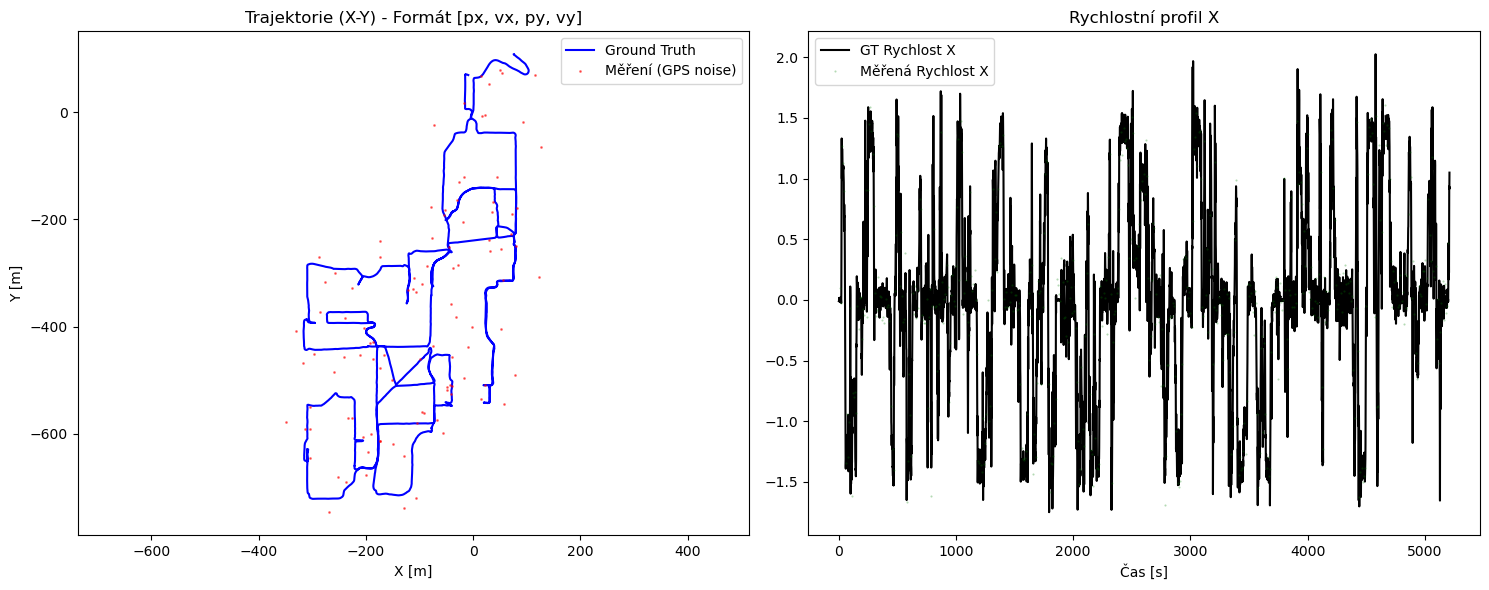

In [3]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# === 1. KONFIGURACE ===
file_path = '../ground_truth/groundtruth_2012-01-22.csv' 
DT = 1.0  # Časový krok

# Parametry šumu pro generování trénovacích dat (Simulace měření)
# Abychom replikovali autory, musíme vygenerovat měření, která odpovídají
# jejich matici R: diag([700, 0.01, 700, 0.01]).
# Tedy: Velký šum na pozici (GPS), malý na rychlosti (Odometrie).
std_pos = np.sqrt(700.0)  # cca 26.4 metrů
std_vel = np.sqrt(0.01)   # 0.1 m/s

# === 2. NAČTENÍ A PŘÍPRAVA SUROVÝCH DAT ===
print(f"Načítám soubor: {file_path}...")
try:
    df = pd.read_csv(file_path, header=None, names=['time', 'x', 'y', 'z', 'r', 'p', 'h'])
    raw_time = df['time'].values / 1e6
    raw_time = raw_time - raw_time[0]
    raw_pos = df[['x', 'y']].values
    
    # --- Resampling (Interpolace) ---
    t_resampled = np.arange(0, raw_time[-1], DT)
    interp_func = interp1d(raw_time, raw_pos, kind='linear', axis=0, fill_value="extrapolate")
    pos_resampled = interp_func(t_resampled) # [N, 2] -> (x, y)
    
    # --- Výpočet rychlosti (Derivace) ---
    vel_resampled = np.zeros_like(pos_resampled)
    vel_resampled[1:] = (pos_resampled[1:] - pos_resampled[:-1]) / DT
    vel_resampled[0] = vel_resampled[1]
    
    # === 3. SKLÁDÁNÍ DO FORMÁTU AUTORŮ [px, vx, py, vy] ===
    # Toto je ta klíčová změna!
    # Sloupec 0: Pozice X
    # Sloupec 1: Rychlost X
    # Sloupec 2: Pozice Y
    # Sloupec 3: Rychlost Y
    
    GT_DATA = np.stack((
        pos_resampled[:, 0], # px
        vel_resampled[:, 0], # vx
        pos_resampled[:, 1], # py
        vel_resampled[:, 1]  # vy
    ), axis=1)
    
    print(f"\n✅ Data seřazena do formátu [px, vx, py, vy]. Shape: {GT_DATA.shape}")

    # === 4. KONVERZE DO PYTORCH A GENEROVÁNÍ MĚŘENÍ ===
    X_target = torch.from_numpy(GT_DATA).float()
    N_samples = X_target.shape[0]
    
    # Generování šumu měření podle specifikace autorů
    # noise_std vektor: [std_px, std_vx, std_py, std_vy]
    noise_std_vec = torch.tensor([std_pos, std_vel, std_pos, std_vel])
    
    # Y = X + Noise
    # Rozšiřujeme noise_std_vec na velikost dat
    noise = torch.randn(N_samples, 4) * noise_std_vec
    Y_measured = X_target + noise
    
    print(f"Měření vygenerována (Simulace GPS+Odo). Shape: {Y_measured.shape}")
    print(f"  -> Šum polohy (std): {std_pos:.2f} m")
    print(f"  -> Šum rychlosti (std): {std_vel:.2f} m/s")

    # === 5. ROZDĚLENÍ TRAIN / VAL / TEST ===
    n_train = int(0.6 * N_samples)
    n_val = int(0.2 * N_samples)
    n_test = N_samples - n_train - n_val
    
    train_input = Y_measured[:n_train]
    train_target = X_target[:n_train]
    
    val_input = Y_measured[n_train:n_train+n_val]
    val_target = X_target[n_train:n_train+n_val]
    
    test_input = Y_measured[n_train+n_val:]
    test_target = X_target[n_train+n_val:]
    
    print(f"Dataset rozdělen: Train={len(train_input)}, Val={len(val_input)}, Test={len(test_input)}")

    # === 6. VIZUALIZACE KONTROLY ===
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    
    # Pro vizualizaci musíme brát správné sloupce z nového GT_DATA
    # X=0, VX=1, Y=2, VY=3
    
    # Trajektorie (X vs Y) -> Sloupec 0 vs Sloupec 2
    ax[0].plot(GT_DATA[:, 0], GT_DATA[:, 2], 'b-', label='Ground Truth')
    # Vykreslíme i kousek měření (jen pro představu šumu), bereme jen každý 50. bod ať to není čmouha
    ax[0].plot(Y_measured[::50, 0], Y_measured[::50, 2], 'r.', markersize=2, alpha=0.5, label='Měření (GPS noise)')
    ax[0].set_title('Trajektorie (X-Y) - Formát [px, vx, py, vy]')
    ax[0].set_xlabel('X [m]')
    ax[0].set_ylabel('Y [m]')
    ax[0].axis('equal')
    ax[0].legend()
    
    # Rychlost X (VX) -> Sloupec 1
    ax[1].plot(t_resampled, GT_DATA[:, 1], 'k-', label='GT Rychlost X')
    ax[1].plot(t_resampled[::10], Y_measured[::10, 1], 'g.', markersize=1, alpha=0.3, label='Měřená Rychlost X')
    ax[1].set_title('Rychlostní profil X')
    ax[1].set_xlabel('Čas [s]')
    ax[1].legend()
    
    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print(f"❌ CHYBA: Soubor '{file_path}' nenalezen.")
except Exception as e:
    print(f"❌ CHYBA: {e}")

KeyboardInterrupt: 

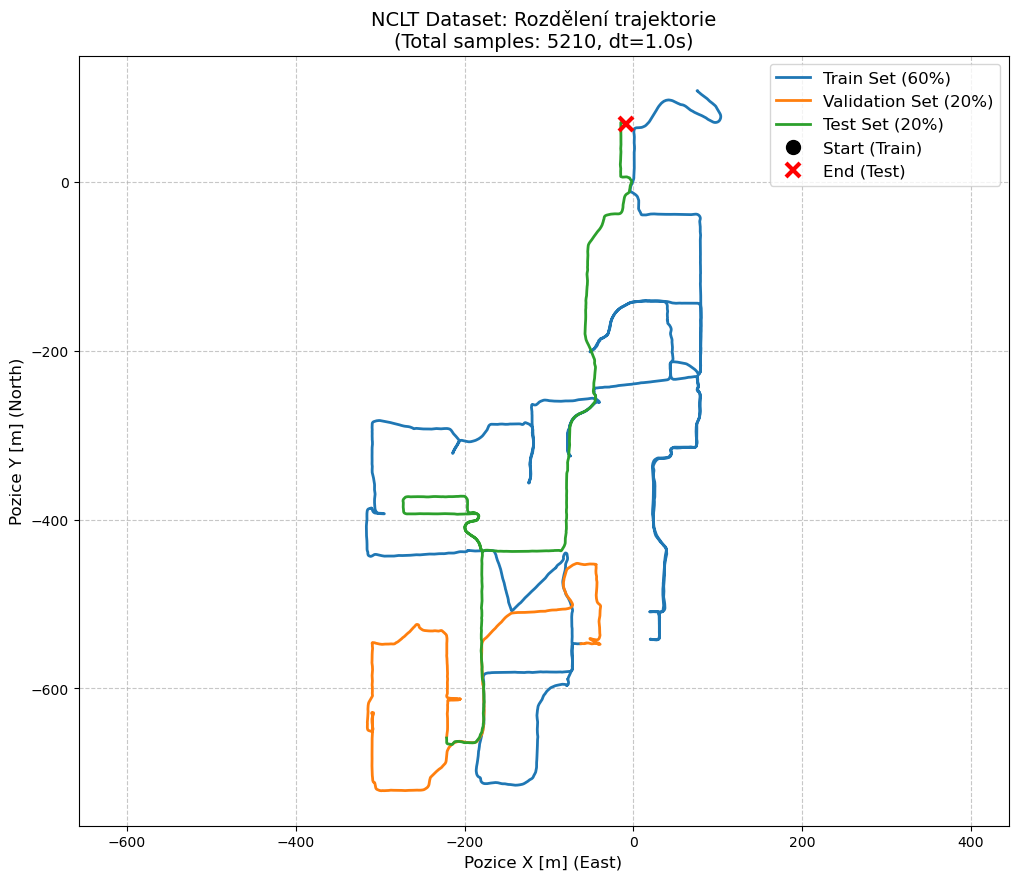

In [ ]:
import matplotlib.pyplot as plt

# === VIZUALIZACE ROZDĚLENÍ DATASETU ===

plt.figure(figsize=(12, 10))

# 1. Vykreslení Trénovací části
# Musíme převést tenzory zpět na numpy (a pro jistotu na CPU, kdyby byly na GPU)
plt.plot(train_target[:, 0].cpu().numpy(), 
         train_target[:, 2].cpu().numpy(), 
         label='Train Set (60%)', color='#1f77b4', linewidth=2)

# 2. Vykreslení Validační části
plt.plot(val_target[:, 0].cpu().numpy(), 
         val_target[:, 2].cpu().numpy(), 
         label='Validation Set (20%)', color='#ff7f0e', linewidth=2)

# 3. Vykreslení Testovací části
plt.plot(test_target[:, 0].cpu().numpy(), 
         test_target[:, 2].cpu().numpy(), 
         label='Test Set (20%)', color='#2ca02c', linewidth=2)

# Zvýraznění začátku a konce
plt.plot(train_target[0, 0].cpu(), train_target[0, 2].cpu(), 'ko', markersize=10, label='Start (Train)')
plt.plot(test_target[-1, 0].cpu(), test_target[-1, 2].cpu(), 'rx', markersize=10, markeredgewidth=3, label='End (Test)')

# Formátování grafu
plt.title(f'NCLT Dataset: Rozdělení trajektorie\n(Total samples: {N_samples}, dt={DT}s)', fontsize=14)
plt.xlabel('Pozice X [m] (East)', fontsize=12)
plt.ylabel('Pozice Y [m] (North)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.axis('equal')  # Důležité: Aby mapa nebyla deformovaná

plt.tight_layout()
plt.show()

# Model definition

In [ ]:
import torch
import math
import Systems # Předpokládám, že toto je tvůj modul s třídou DynamicSystem

# Nastavení zařízení
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#########################
### Design Parameters ###
### (Dle autorů)      ###
#########################

# 1. Rozměry
# Stav: [px, vx, py, vy] (Všimni si pořadí!)
m = 4 
n = 4 
delta_t = 1.0 # Sampling NCLT datasetu

# 2. Dynamika (F)
# x_{t+1} = x_t + v_t * dt
# v_{t+1} = v_t
F_dim = torch.tensor([[1.0, delta_t],
                      [0.0, 1.0]])

# Vytvoření 4x4 matice pro X a Y osy
# Výsledek je blokově diagonální, což znamená pořadí stavů: [px, vx, py, vy]
F_design = torch.block_diag(F_dim, F_dim).float()

# 3. Měření (H)
# Měříme vše: [px, vx, py, vy]
H_design = torch.eye(n).float()

# 4. Šum procesu (Q)
# Autoři definují Q diagonálně závislé na čase
lambda_q_mod = 1.0
Q_dim = torch.diagflat(torch.tensor([delta_t, delta_t]))
Q_design = (lambda_q_mod**2) * torch.block_diag(Q_dim, Q_dim).float()

# 5. Šum měření (R) - TOTO JE KLÍČOVÉ PRO REPLIKACI
# 700 = Obrovská chyba polohy (GPS) -> Filtr ji bude potlačovat
# 0.01 = Malá chyba rychlosti (Odometrie) -> Filtr jí bude věřit
# Pořadí odpovídá stavům: [Pos_X, Vel_X, Pos_Y, Vel_Y]
R_design = torch.tensor([[700.0, 0.0,   0.0,   0.0],
                         [0.0,   0.01,  0.0,   0.0],
                         [0.0,   0.0,   700.0, 0.0],
                         [0.0,   0.0,   0.0,   0.01]]).float()

# 6. Počáteční podmínky
# Autoři začínají na nule
m1x_0 = torch.zeros(m, 1).float()      # Mean
m2x_0 = torch.eye(m).float() * 1e-5

print("\nInicializuji systém dle parametrů KalmanNet (Author's replication)...")
print(f"Dimenze stavu: {m}, Dimenze měření: {n}")
print(f"R (diagonal): {torch.diagonal(R_design)}")

# === INICIALIZACE SYSTÉMŮ ===

# Sys True (Generativní model - pokud bychom generovali syntetická data)
# Pro NCLT data se toto tolik nepoužije (data načítáme), ale pro konzistenci nastavíme stejně.
sys_true = Systems.DynamicSystem(
    state_dim=m, obs_dim=n,
    Ex0=m1x_0, P0=m2x_0,
    Q=Q_design, R=R_design,
    F=F_design, H=H_design,
    device=device
)

# Sys Model (To, co ví KalmanNet/Filtr)
sys_model = Systems.DynamicSystem(
    state_dim=m, obs_dim=n,
    Ex0=m1x_0, P0=m2x_0,
    Q=Q_design, R=R_design,
    F=F_design, H=H_design,
    device=device
)

print("... Systémy inicializovány.")
print("POZOR: Tento model očekává pořadí stavů [px, vx, py, vy].")

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# === 1. KONFIGURACE ===
TRAIN_SEQ_LEN = 50    # Délka sekvence pro RNN
VAL_SEQ_LEN = 200
TEST_SEQ_LEN = n_test
STRIDE = 10     # Posun okna (pro trénink s překryvem)
BATCH_SIZE = 128 # Velikost dávky

def create_sequences(X, Y, seq_len, stride=1):
    """
    Rozseká dlouhé tenzory [Total_Len, Dim] na sekvence [N_seq, Seq_Len, Dim].
    """
    xs = []
    ys = []
    num_samples = X.shape[0]
    
    for i in range(0, num_samples - seq_len + 1, stride):
        x_seq = X[i : i+seq_len, :]
        y_seq = Y[i : i+seq_len, :]
        xs.append(x_seq)
        ys.append(y_seq)
        
    if len(xs) == 0:
        return torch.empty(0, seq_len, X.shape[1]), torch.empty(0, seq_len, Y.shape[1])
        
    return torch.stack(xs), torch.stack(ys)

def clean_sequences(X_seq, Y_seq, name="Dataset"):
    """
    Filtruje sekvence, které obsahují jakékoliv NaN nebo Inf hodnoty.
    """
    if X_seq.numel() == 0:
        print(f"⚠️ {name}: Prázdný vstup!")
        return X_seq, Y_seq

    # Zkontrolujeme NaN/Inf pro každou sekvenci zvlášť
    # X_seq shape: [N, Seq_Len, Dim] -> reshape na [N, -1] pro kontrolu celého řádku
    is_nan_x = torch.isnan(X_seq).reshape(X_seq.shape[0], -1).any(dim=1)
    is_inf_x = torch.isinf(X_seq).reshape(X_seq.shape[0], -1).any(dim=1)
    
    is_nan_y = torch.isnan(Y_seq).reshape(Y_seq.shape[0], -1).any(dim=1)
    is_inf_y = torch.isinf(Y_seq).reshape(Y_seq.shape[0], -1).any(dim=1)
    
    # Maska vadných dat (pokud je chyba v X nebo v Y)
    invalid_mask = is_nan_x | is_inf_x | is_nan_y | is_inf_y
    
    # Vybereme jen ta dobrá
    valid_mask = ~invalid_mask
    
    X_clean = X_seq[valid_mask]
    Y_clean = Y_seq[valid_mask]
    
    n_dropped = invalid_mask.sum().item()
    if n_dropped > 0:
        print(f"⚠️ {name}: Odstraněno {n_dropped} vadných sekvencí (NaN/Inf). Zbývá: {len(X_clean)}")
    else:
        print(f"✅ {name}: Data jsou čistá. ({len(X_clean)} sekvencí)")
        
    return X_clean, Y_clean

print("--- ZPRACOVÁNÍ DAT ---")

# === 2. TVORBA SEKVENCÍ A PŘETYPOVÁNÍ ===
# Používáme .float() hned zde, abychom vyřešili Double vs Float error
print("Generuji sekvence...")
train_X_raw, train_Y_raw = create_sequences(train_target.float(), train_input.float(), TRAIN_SEQ_LEN, STRIDE)
val_X_raw, val_Y_raw = create_sequences(val_target.float(), val_input.float(), VAL_SEQ_LEN, VAL_SEQ_LEN)
test_X_raw, test_Y_raw = create_sequences(test_target.float(), test_input.float(), TEST_SEQ_LEN, TEST_SEQ_LEN)

# === 3. ČIŠTĚNÍ DAT (NAN/INF FILTER) ===
print("\nFiltruji NaN hodnoty...")
train_X_seq, train_Y_seq = clean_sequences(train_X_raw, train_Y_raw, "Train")
val_X_seq, val_Y_seq = clean_sequences(val_X_raw, val_Y_raw, "Val")
test_X_seq, test_Y_seq = clean_sequences(test_X_raw, test_Y_raw, "Test")

# === 4. VYTVOŘENÍ DATALOADERŮ ===
print("\nVytvářím DataLoadery...")
# Train: Shuffle=True
train_dataset = TensorDataset(train_X_seq, train_Y_seq)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Val/Test: Shuffle=False
val_dataset = TensorDataset(val_X_seq, val_Y_seq)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_dataset = TensorDataset(test_X_seq, test_Y_seq)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\n✅ HOTOVO. Připraveno k tréninku.")
print(f"Batch shape: {next(iter(train_loader))[0].shape}")

In [ ]:

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import os
import random
import csv
from datetime import datetime
import pandas as pd
from copy import deepcopy
from state_NN_models import StateBayesianKalmanNet

# Nastavení seedu pro reprodukovatelnost tohoto běhu
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
state_knet = StateBayesianKalmanNet(sys_model, device=device, hidden_size_multiplier=10,output_layer_multiplier=4,num_gru_layers=1,
                                    init_max_dropout=0.8,init_min_dropout=0.6).to(device)
trainer.train_BayesianKalmanNet(
    model=state_knet, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    device=device, 
    total_train_iter=800, 
    learning_rate=5e-4,
    warmup_iterations=250,
    clip_grad=1.0,
    J_samples=10,
    validation_period=5,
    logging_period=5,
    weight_decay_=1e-3
)

In [ ]:
if False:
    import torch
    import os

    # Protože jsi trénink přerušil, nemáme slovník s metrikami automaticky.
    # Musíme uložit přímo model 'state_knet'.

    # 1. Definuj cestu (Metriky si do názvu musíš dopsat ručně podle toho, co jsi viděl v logu naposledy,
    # nebo použij obecný název, abys o model nepřišel).
    save_path = 'best_BayesianKalmanNet_linear_velocity_integration.pth'

    # Pokud si pamatuješ hodnoty z logu (např. ANEES 23.5), můžeš je tam dopsat ručně:
    # save_path = 'best_kalmannet_nclt_sensor_fusion_ANEES23.57_MSE8.17_interrupted.pth'

    # 2. Uložení
    # DŮLEŽITÉ: Voláme .state_dict() přímo na objektu state_knet (nebo trained_knet, pokud jsi ho přiřadil)
    # Nepoužíváme závorky ['final_model'], protože state_knet UŽ JE ten model.
    torch.save(state_knet.state_dict(), save_path)

    print(f"\n✅ Záchrana modelu úspěšná! Uloženo do: {save_path}")

if False:
    import os
    # trained_knet = state_knet 
    # Přístup k metrikám ve slovníku je správně (přes závorky [])
    print(f"   -> Best ANEES: {trained_knet['best_val_anees']:.4f}")
    print(f"   -> Best MSE:   {trained_knet['best_val_mse']:.4f}")
    save_path = f'best_kalmanFormer_nclt_sensor_fusion_ANEES{trained_knet["best_val_anees"]:.4f}_MSE{trained_knet["best_val_mse"]:.4f}_nejlepsi_test_vysledky.pth '

    # OPRAVA: Musíš vytáhnout model ze slovníku pomocí klíče 'final_model'
    # A teprve na něm zavolat .state_dict()
    torch.save(trained_knet['final_model'].state_dict(), save_path)

    print(f"\n✅ Model úspěšně uložen do: {save_path}")


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import Filters  # Tvůj modul s filtry
from utils import utils # Tvůj modul pro ANEES

# ==============================================================================
# 0. KONFIGURACE
# ==============================================================================
J_SAMPLES = 50  # Počet vzorků pro Monte Carlo Dropout (Ensemble)

# Příprava BKN modelu
try:
    trained_model_bkn = state_knet
    # DŮLEŽITÉ: Pro BKN musí být model v režimu TRAIN (aby fungoval Dropout)
    trained_model_bkn.train() 
    print(f"INFO: Bayesian KalmanNet (BKN) připraven (J={J_SAMPLES}).")
except NameError:
    raise NameError("Chyba: Proměnná 'state_bkn' neexistuje. Spusťte nejprve trénink BKN.")

# Inicializace klasických filtrů pro srovnání
print("Inicializuji EKF, UKF a PF...")
ekf_filter = Filters.ExtendedKalmanFilter(sys_model)
ukf_filter = Filters.UnscentedKalmanFilter(sys_model)
pf_filter = Filters.ParticleFilter(sys_model, num_particles=10000)

# ==============================================================================
# 1. VYHODNOCOVACÍ SMYČKA
# ==============================================================================
metrics = {
    'BKN':  {'mse': [], 'anees': []},
    'EKF':  {'mse': [], 'anees': []},
    'UKF':  {'mse': [], 'anees': []},
    'PF':   {'mse': [], 'anees': []}
}

traj_idx = 0
total_trajectories = len(test_loader.dataset)

print(f"\nVyhodnocuji {total_trajectories} sekvencí...")

with torch.no_grad():
    for batch_data in test_loader:
        # Robustní rozbalení dat (x, y, u)
        if len(batch_data) == 3:
            x_true_batch, y_meas_batch, u_input_batch = batch_data
        else:
            x_true_batch, y_meas_batch = batch_data
            # Dummy u_input pokud loader vrací jen x,y (pro jistotu)
            u_input_batch = torch.zeros(x_true_batch.shape[0], x_true_batch.shape[1], 4).to(device)

        batch_size = x_true_batch.shape[0]
        
        for i in range(batch_size):
            traj_idx += 1
            
            # Data jedné trajektorie
            y_seq = y_meas_batch[i].to(device)    # [T, Obs]
            x_true = x_true_batch[i].to(device)   # [T, State]
            seq_len = y_seq.shape[0]

            # Inicializace (Ground Truth)
            # x_true[0] je vektor [m], uděláme z něj [1, m] pro sítě a [m, 1] pro filtry
            init_state_row = x_true[0, :].unsqueeze(0) 
            init_state_col = x_true[0, :].unsqueeze(1) 
            
            # ---------------------------------------------------------
            # 1. Bayesian KalmanNet (BKN) - ENSEMBLE LOGIKA
            # ---------------------------------------------------------
            
            # A. Reset: Replikujeme počáteční stav pro J vzorků
            # Tvar: [J, State_Dim]
            bkn_init_batch = init_state_row.repeat(J_SAMPLES, 1) 
            trained_model_bkn.reset(batch_size=J_SAMPLES, initial_state=bkn_init_batch)
            
            # Ukládáme historii ensemblu. 
            # samples_history bude list délky T. Každý prvek je tensor [J, m].
            samples_history = [bkn_init_batch] 
            
            # B. Smyčka v čase (Forward Pass s Dropoutem)
            for t in range(1, seq_len):
                # Rozmnožení vstupu pro celý batch J
                # y_t: [J, Obs_Dim], u_t: [J, Input_Dim]
                y_t = y_seq[t].unsqueeze(0).repeat(J_SAMPLES, 1) 
                
                # Krok sítě (Dropout je aktivní díky .train())
                # x_est_j: [J, State_Dim]
                x_est_j, _ = trained_model_bkn.step(y_t) 
                
                samples_history.append(x_est_j)
            
            # C. Zpracování Ensemblu (Statistika)
            # Stackneme do tensoru: [T, J, m]
            full_ensemble = torch.stack(samples_history, dim=0)
            
            # 1. Průměr (Mean Estimate) -> [T, m]
            x_bkn_mean = torch.mean(full_ensemble, dim=1) 
            
            # 2. Kovariance (Empirická z ensemblu) -> [T, m, m]
            # Vzorec: P = 1/(J-1) * sum((x_j - x_mean) @ (x_j - x_mean).T)
            residuals = full_ensemble - x_bkn_mean.unsqueeze(1) # [T, J, m]
            # Batch násobení: [T, m, J] @ [T, J, m] -> [T, m, m]
            residuals_perm = residuals.permute(0, 2, 1) 
            P_bkn = torch.bmm(residuals_perm, residuals) / (J_SAMPLES - 1)
            
            # Uložení metrik BKN
            metrics['BKN']['mse'].append(F.mse_loss(x_bkn_mean[1:], x_true[1:]).item())
            metrics['BKN']['anees'].append(utils.calculate_anees_vectorized(
                x_true[1:].unsqueeze(0), 
                x_bkn_mean[1:].unsqueeze(0), 
                P_bkn[1:].unsqueeze(0)
            ))

            # ---------------------------------------------------------
            # 2. Klasické Filtry (EKF, UKF, PF)
            # ---------------------------------------------------------
            try:
                # EKF
                res_ekf = ekf_filter.process_sequence(y_seq, Ex0=init_state_col, P0=sys_model.P0)
                metrics['EKF']['mse'].append(F.mse_loss(res_ekf['x_filtered'][1:], x_true[1:]).item())
                metrics['EKF']['anees'].append(utils.calculate_anees_vectorized(
                    x_true[1:].unsqueeze(0), res_ekf['x_filtered'][1:].unsqueeze(0), res_ekf['P_filtered'][1:].unsqueeze(0)))
                
                # UKF
                res_ukf = ukf_filter.process_sequence(y_seq, Ex0=init_state_col, P0=sys_model.P0)
                metrics['UKF']['mse'].append(F.mse_loss(res_ukf['x_filtered'][1:], x_true[1:]).item())
                metrics['UKF']['anees'].append(utils.calculate_anees_vectorized(
                    x_true[1:].unsqueeze(0), res_ukf['x_filtered'][1:].unsqueeze(0), res_ukf['P_filtered'][1:].unsqueeze(0)))
                
                # PF
                res_pf = pf_filter.process_sequence(y_seq, Ex0=init_state_col, P0=sys_model.P0)
                metrics['PF']['mse'].append(F.mse_loss(res_pf['x_filtered'][1:], x_true[1:]).item())
                metrics['PF']['anees'].append(utils.calculate_anees_vectorized(
                    x_true[1:].unsqueeze(0), res_pf['x_filtered'][1:].unsqueeze(0), res_pf['P_filtered'][1:].unsqueeze(0)))
            
            except Exception as e:
                # print(f"Chyba filtru: {e}")
                pass 

            if traj_idx % 50 == 0:
                print(f"  ... {traj_idx} hotovo")

# ==============================================================================
# 2. FINÁLNÍ VÝPIS
# ==============================================================================
def avg(l): return np.mean(l) if len(l)>0 else np.nan

print("\n" + "="*90)
print(f"SROVNÁNÍ BKN vs KLASICKÉ FILTRY (NCLT Dataset)")
print("="*90)
print(f"{'Model':<25} | {'MSE':<15} | {'RMSE [m]':<15} | {'ANEES':<15}")
print("-" * 90)

for name in ['BKN', 'EKF', 'UKF', 'PF']:
    m = avg(metrics[name]['mse'])
    a = avg(metrics[name]['anees'])
    rmse = np.sqrt(m) if not np.isnan(m) else np.nan
    
    print(f"{name:<25} | {m:<15.4f} | {rmse:<15.4f} | {a:<15.4f}")

print("="*90)
print(f"Pozn: Ideální ANEES pro state_dim={sys_model.state_dim} je cca {sys_model.state_dim}.")

In [ ]:
import matplotlib.pyplot as plt

# === VIZUALIZACE POSLEDNÍ TESTOVACÍ TRAJEKTORIE ===

# 1. Převod tenzorů na NumPy pole (pro vykreslování)
# Bereme data z poslední iterace předchozí smyčky
gt_np = x_true.cpu().numpy()
knet_np = full_x_hat_knet.cpu().numpy()
ekf_np = full_x_hat_ekf.cpu().numpy()
# (Pokud chceš i UKF, odkomentuj:)
ukf_np = full_x_hat_ukf.cpu().numpy()

# Časová osa (kroky)
time_steps = np.arange(gt_np.shape[0])

# Připomínka indexů (Author's format):
# 0: Pos X, 1: Vel X, 2: Pos Y, 3: Vel Y
idx_px, idx_vx, idx_py, idx_vy = 0, 1, 2, 3

# === GRAF 1: 2D TRAJEKTORIE (MAPA) ===
plt.figure(figsize=(10, 8))
plt.title(f"Porovnání odhadu trajektorie (Testovací sekvence č. {traj_idx})", fontsize=14)

# Ground Truth
plt.plot(gt_np[:, idx_px], gt_np[:, idx_py], 'k-', linewidth=2, label='Ground Truth (GT)', alpha=0.8)

# EKF
plt.plot(ekf_np[:, idx_px], ekf_np[:, idx_py], 'r--', linewidth=1.5, label='EKF (Standard)')

# KalmanNet
plt.plot(knet_np[:, idx_px], knet_np[:, idx_py], 'b-.', linewidth=2, label='KalmanNet (Trained)')

# (Volitelně UKF)
plt.plot(ukf_np[:, idx_px], ukf_np[:, idx_py], 'g:', linewidth=1.5, label='UKF', alpha=0.7)

# Start a Cíl
plt.plot(gt_np[0, idx_px], gt_np[0, idx_py], 'ko', markersize=8, label='Start')
plt.plot(gt_np[-1, idx_px], gt_np[-1, idx_py], 'kx', markersize=8, label='Cíl')

plt.xlabel("Pozice X [m]")
plt.ylabel("Pozice Y [m]")
plt.legend()
plt.grid(True)
plt.axis('equal') # Aby mapa nebyla deformovaná
plt.show()

# === GRAF 2: DETAILNÍ PRŮBĚHY STAVŮ ===
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Detailní průběh stavů v čase", fontsize=16)

# --- Pozice X ---
axs[0, 0].plot(time_steps, gt_np[:, idx_px], 'k-', label='GT')
axs[0, 0].plot(time_steps, ekf_np[:, idx_px], 'r--', label='EKF')
axs[0, 0].plot(time_steps, knet_np[:, idx_px], 'b-.', label='KalmanNet')
axs[0, 0].set_title("Pozice X")
axs[0, 0].set_ylabel("Metry")
axs[0, 0].grid(True)
axs[0, 0].legend()

# --- Pozice Y ---
axs[0, 1].plot(time_steps, gt_np[:, idx_py], 'k-', label='GT')
axs[0, 1].plot(time_steps, ekf_np[:, idx_py], 'r--', label='EKF')
axs[0, 1].plot(time_steps, knet_np[:, idx_py], 'b-.', label='KalmanNet')
axs[0, 1].set_title("Pozice Y")
axs[0, 1].set_ylabel("Metry")
axs[0, 1].grid(True)

# --- Rychlost X ---
axs[1, 0].plot(time_steps, gt_np[:, idx_vx], 'k-', label='GT', alpha=0.5)
axs[1, 0].plot(time_steps, ekf_np[:, idx_vx], 'r--', label='EKF')
axs[1, 0].plot(time_steps, knet_np[:, idx_vx], 'b-.', label='KalmanNet')
axs[1, 0].set_title("Rychlost X (Velocity)")
axs[1, 0].set_ylabel("m/s")
axs[1, 0].grid(True)

# --- Rychlost Y ---
axs[1, 1].plot(time_steps, gt_np[:, idx_vy], 'k-', label='GT', alpha=0.5)
axs[1, 1].plot(time_steps, ekf_np[:, idx_vy], 'r--', label='EKF')
axs[1, 1].plot(time_steps, knet_np[:, idx_vy], 'b-.', label='KalmanNet')
axs[1, 1].set_title("Rychlost Y (Velocity)")
axs[1, 1].set_ylabel("m/s")
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()